## Dataset

Name: Census Income Dataset
URL: https://archive.ics.uci.edu/dataset/2/adult

In [58]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check Labels

In [60]:
y_train.value_counts()

income
<=50K     19784
<=50K.     9957
>50K       6279
>50K.      3053
Name: count, dtype: int64

In [79]:
# remove '.' and ',' from labels

y_train = y_train.apply(lambda x: x.str.replace('.', '').replace(',', ''))
y_test = y_test.apply(lambda x: x.str.replace('.', '').replace(',', ''))

<Axes: xlabel='income'>

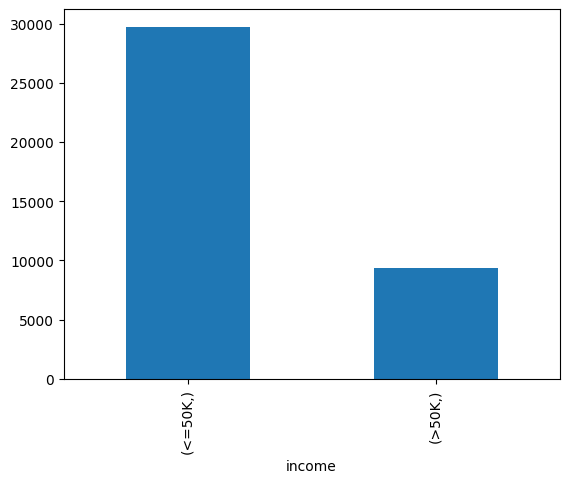

In [62]:
y_train.value_counts().plot(kind='bar')

## Check features

In [63]:
X_train.shape

(39073, 14)

In [64]:
X_train.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
37193,32,Private,50753,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
31093,45,State-gov,144351,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States
33814,35,Local-gov,252217,12th,8,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States
14500,64,Private,69525,HS-grad,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,20,United-States
23399,63,Self-emp-not-inc,28612,HS-grad,9,Widowed,Sales,Not-in-family,White,Male,0,0,70,United-States


In [65]:
# Cardinality

X_train.nunique().sort_values(ascending=False) 

fnlwgt            24635
capital-gain        121
capital-loss         98
hours-per-week       96
age                  74
native-country       41
education            16
education-num        16
occupation           15
workclass             9
marital-status        7
relationship          6
race                  5
sex                   2
dtype: int64

<Axes: ylabel='Frequency'>

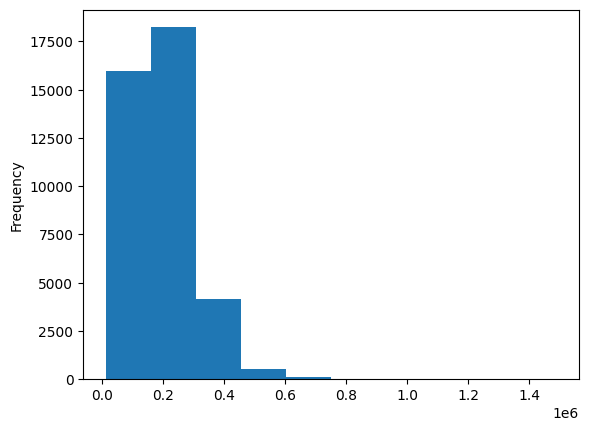

In [66]:
# What is fnlwgt?

drop_cols = ['fnlwgt']

X_train['fnlwgt'].plot(kind='hist')  # looks like the final income, we should drop it

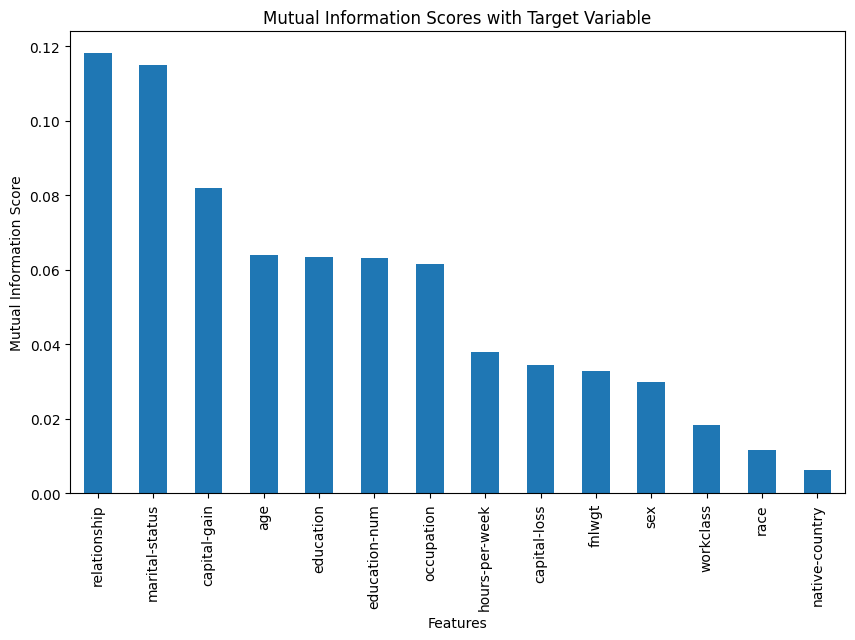

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def plot_categorical_correlation(df, target_df):
    # Ensure the inputs are pandas DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The input data must be a pandas DataFrame.")
    if not isinstance(target_df, pd.DataFrame):
        raise ValueError("The target must be a pandas DataFrame.")

    # Check if target DataFrame has only one column
    if target_df.shape[1] != 1:
        raise ValueError("The target DataFrame must have exactly one column.")

    # Extract the target Series from the DataFrame
    target_series = target_df.iloc[:, 0]

    # Label encoding for categorical features
    le = LabelEncoder()
    encoded_df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

    # Label encoding for the target if it's categorical
    if target_series.dtype == 'object':
        target_series = le.fit_transform(target_series)

    # Calculate the mutual information scores
    mi_scores = mutual_info_classif(encoded_df, target_series, discrete_features='auto')

    # Create a Series for easy plotting
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=encoded_df.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='bar')
    plt.title('Mutual Information Scores with Target Variable')
    plt.ylabel('Mutual Information Score')
    plt.xlabel('Features')
    plt.show()

plot_categorical_correlation(X_train, y_train)

## Train Model

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from vowpalwabbit.sklearn import VWClassifier

enc = OneHotEncoder(
    handle_unknown='ignore'
    )

X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)


model = VWClassifier(
    loss_function='logistic',
    quiet=False,
    passes=1,
    # interactions='::',
)


# fit model
model.fit(X_train_enc, y_train)

using no cache
Reading datafile = none
num sources = 0
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
Enabled learners: gd, scorer-identity, count_label
Input label = SIMPLE
Output pred = SCALAR
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
0.693147 0.693147            1            1.0        -1.0000         0.0000       15
0.920684 1.148220            2            2.0         1.0000        -0.7667       15
0.737263 0.553842            4            4.0        -1.0000        -0.5785       15
0.713211 0.689159            8            8.0         1.0000        -1.5516       15
0.702740 0.692268           16           16.0        -1.0000        -0.9424       15
0.622506 0.542272           32           32.0        -1.0000        -0.7096       15
0.542149 0.461792           64           64.0        -1.0000        -1.6797       15
0.498799 0.455449 

VWClassifier(classes_: ['<=50K' '>50K'], coef_: , convert_labels: True, convert_to_vw: True, loss_function: logistic, passes: 1, quiet: False, vw_: <vowpalwabbit.pyvw.Workspace object at 0xffff2d105450>)

In [94]:
# classification report

from sklearn.metrics import classification_report

y_pred = model.predict(X_test_enc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7414
        >50K       0.77      0.62      0.69      2355

    accuracy                           0.86      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769

